# testing template morphing

Fundamental to including systematic uncertainties into the fit of data is morphing of the templates used to model the data.  The scheme that we have adopted uses a quadratic interpolation when the nuisance parameters is in the range [-1, 1] and linear extrapolation outside.  

In [2]:
## imports and configuration
%cd '/home/naodell/work/wbr/analysis'
#%load_ext autoreload

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import scripts.plot_tools as pt
import scripts.fit_helpers as fh
from nllfit.nllfitter import ScanParameters

np.set_printoptions(precision=3)
rc_params = {
             'figure.figsize': (10, 10),
             'axes.labelsize': 20,
             'axes.facecolor': 'white',
             'axes.titlesize':'x-large',
             'legend.fontsize': 20,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'font.size':18,
             'font.sans-serif':['Arial', 'sans-serif'],
             'mathtext.sf':'Arial',
             'lines.markersize':8.,
             'lines.linewidth':2.5,
            }
matplotlib.rcParams.update(rc_params)

%connect_info

/home/naodell/work/wbr/analysis
{
  "shell_port": 53221,
  "iopub_port": 55017,
  "stdin_port": 47831,
  "control_port": 48809,
  "hb_port": 32841,
  "ip": "127.0.0.1",
  "key": "619cf376-a3e247ecabea91b54cc9051b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-f3463f88-215d-4f4c-851a-738812793bcf.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# current scheme and problems

In order to account for asymmetry in the expected yield for the up and down variations for a given n.p., it is required to use at least a second order polynomial for the template morphing mapping.  This quadratic dependence is limited to the range [-1, 1] and large variations are linear.  For a large range of scenarios this is fine, but becomes problematic when the variation are very asymmetric or, in the worst case, both increase or decrease the yield.

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


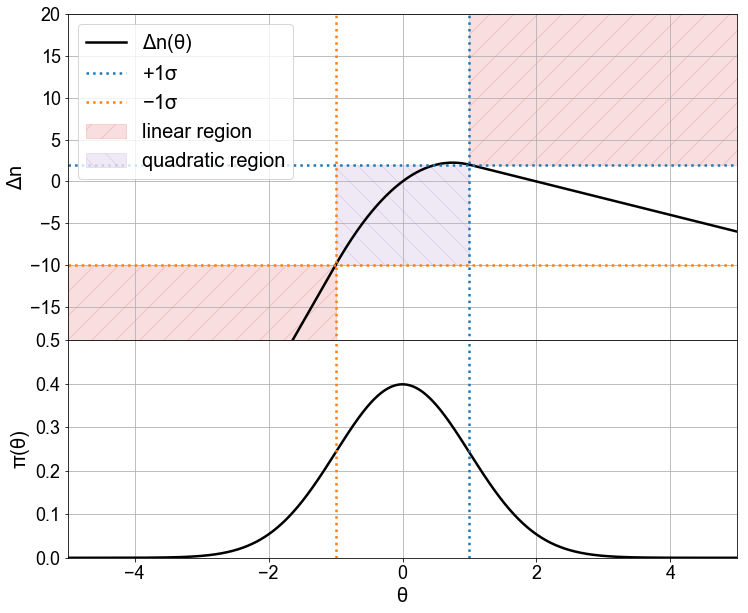

In [3]:
# plot morphing function for a single bin
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
dt_down, dt_up = -10, 2 
delta_plus, delta_minus = dt_up + dt_down, dt_up - dt_down
x_low = np.linspace(-5, -1, 400)
x_mid = np.linspace(-1, 1, 200)
x_high = np.linspace(1, 5, 400)
f_low = (-delta_plus + 0.5*delta_minus)*x_low - 0.5*delta_plus
f_mid = 0.5*delta_plus*x_mid**2 + 0.5*delta_minus*x_mid
f_high = (delta_plus + 0.5*delta_minus)*x_high - 0.5*delta_plus

ax.set_ylabel(r'$\Delta n$')
ax.plot(x_low, f_low, 'k-', label=r'$\Delta n(\theta)$')
ax.plot(x_mid, f_mid, 'k-', label='_nolegend_')
ax.plot(x_high, f_high, 'k-', label='_nolegend_')
ax.fill_between([1, 5], [dt_up, dt_up], [100, 100], color='C3', hatch='/', alpha=0.15, label=r'linear region')
ax.fill_between([-5, -1], [-100, -100], [dt_down, dt_down], color='C3', hatch='/', alpha=0.15, label='_nolegend_')
ax.fill_between([-1, 1], [dt_down, dt_down], [dt_up, dt_up], color='C4', hatch='\\', alpha=0.15, label='quadratic region')
ax.plot([1, 1], [-100, 100], 'C0:', label=r'$+1 \sigma$')
ax.plot([-1, -1], [-100, 100], 'C1:', label=r'$-1 \sigma$')
ax.plot([-5, 5], [dt_up, dt_up], 'C0:', label='_nolegend_')
ax.plot([-5, 5], [dt_down, dt_down], 'C1:', label='_nolegend_')
ax.set_ylim(-19, 20)
ax.grid()
ax.legend()

ax = axes[1]
from scipy.stats import norm
x = np.concatenate([x_low, x_mid, x_high])
ax.plot(x, norm.pdf(x), 'k')
ax.plot([1, 1], [0, 1], 'C0:', label=r'$+1 \sigma$')
ax.plot([-1, -1], [0, 1], 'C1:', label=r'$-1 \sigma$')
ax.set_ylabel(r'$\pi(\theta)$')
ax.set_xlabel(r'$\theta$')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.5)
ax.grid()

plt.savefig('plots/stats/toy_example_tm.pdf')
plt.show()

## a toy example

To begin we consider a toy example to explore some of the characteristics of template morphing schemes.  For the first case, we'll consider an expnonentially dropping distribution and various types of morphing.

In [57]:
# generate toy data and variations
def func(x, a=1):
    return 0.5*a**3*x**2*np.exp(-a*x)

xmin, xmax = 0, 20
scale = 0.5

rnum = np.random.rand(2, int(1e6))
rnum[0] *= (xmax - xmin)
f_nom = func(rnum[0], scale)
mask_nom = rnum[1] < f_nom
toy_data_nom = rnum[0][mask_nom]
toy_data_up = 1.02*toy_data_nom
toy_data_down = 0.98*toy_data_nom


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


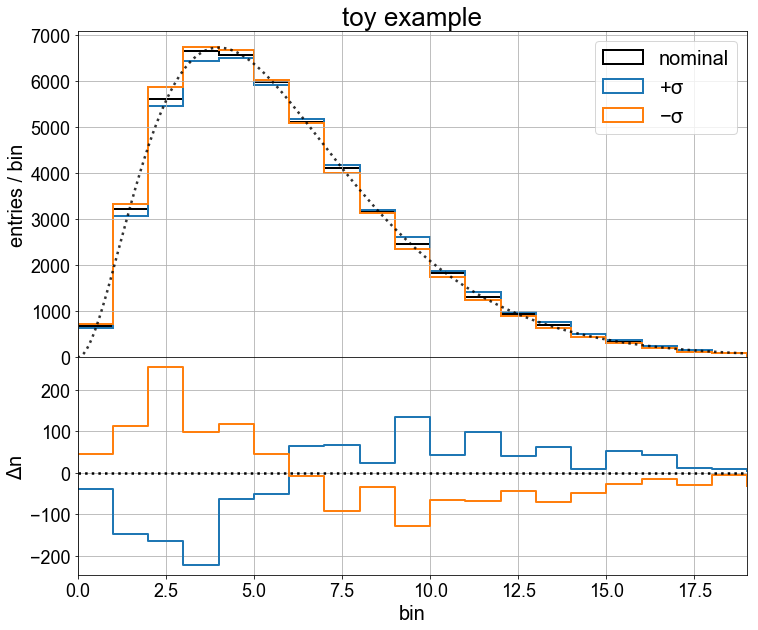

In [58]:
# plot the function and its up and down variants
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
x = np.linspace(xmin, xmax, 1001)
bins = np.linspace(xmin, xmax, 21)
ax.plot(x, toy_data_nom.size*func(x, 0.5), 'k:', alpha=0.8)
h_nom, _, _ = ax.hist(toy_data_nom, bins, histtype='step', linewidth=2, color='k', density=False, label='nominal')
h_up = h_nom*(1 + 0.05*np.sqrt(bins[1:]))
h_down = h_nom*(1 - 0.04*np.sqrt(bins[1:]))
#ax.plot(bins[:-1], h_up, 'C0-', linewidth=2, drawstyle='steps-post', label=r'$+\sigma$')
#ax.plot(bins[:-1], h_down, 'C1-', linewidth=2, drawstyle='steps-post', label=r'$-\sigma$')

h_up, _, _ = ax.hist(toy_data_up, bins, histtype='step', linewidth=2, color='C0', density=False, label=r'$+\sigma$')
h_down, _, _ = ax.hist(toy_data_down, bins, histtype='step', linewidth=2, color='C1', density=False, label=r'$-\sigma$')

ax.set_ylabel('entries / bin')
ax.set_title('toy example')
ax.legend()
ax.grid()

ax = axes[1]
ax.plot(bins[:-1], h_up - h_nom, 'C0-', linewidth=2, drawstyle='steps-post')
ax.plot(bins[:-1], h_down - h_nom, 'C1-', linewidth=2, drawstyle='steps-post')
ax.plot([0, 20], [0, 0], 'k:')
ax.set_xlim(0, 19)
#ax.set_ylim(0.5, 1.5)
ax.set_xlabel('bin')
ax.set_ylabel(r'$\Delta n$')
ax.grid()

plt.savefig('plots/stats/toy_example_emorph.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


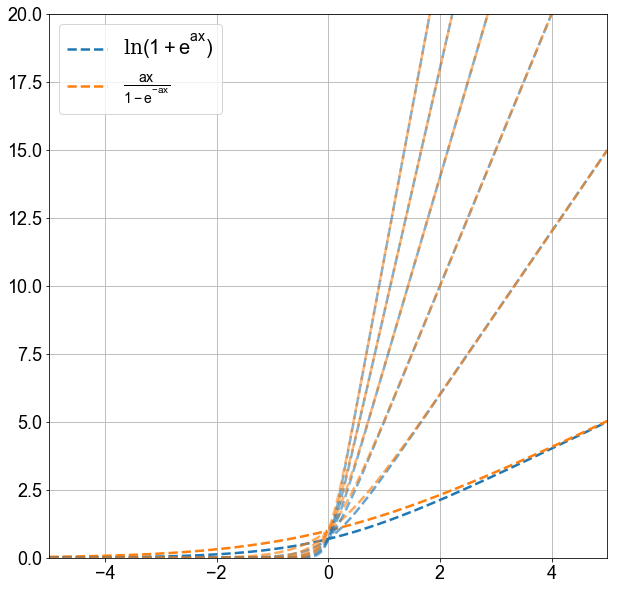

In [24]:
# possible function
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

def softplus(x, a=1, version=0):
    if version == 0:
        return np.log(1 + np.exp(a*x))
    else:
        return a*np.log(1 + np.exp(x))

def logistic_rectifier(x, a=1, version=0):
    if version == 0:
        return a*x/(1 - np.exp(-a*x))
    else:
        return a*x/(1 - np.exp(-a*x))

x = np.linspace(-5, 5, 601)
ax.plot(x, softplus(x), 'C0--', label=r'$\ln(1 + e^{ax})$')
#ax.plot(x, softplus(x, version=1), 'C3--', label=r'$a\ln(1 + e^{x})$')
ax.plot(x, logistic_rectifier(x), 'C1--', label=r'$\frac{ax}{1 - e^{-ax}}$')
#ax.plot(x, logistic_rectifier(x, version=1), 'C4--', label=r'$\frac{ax}{1 - e^{-x}}$')

for a in range(3, 12, 2):
    ax.plot(x, softplus(x, a), 'C0--', alpha=0.5*(1 + 1/a), label='_nolegend_')
    #ax.plot(x, softplus(x, a, version=1), 'C3--', label='_nolegend_')
    ax.plot(x, logistic_rectifier(x, a), 'C1--', alpha=0.5*(1 + 1/a), label='_nolegend_')
    #ax.plot(x, logistic_rectifier(x, a, version=1), 'C4--', label='_nolegend_')
    
ax.set_ylim(0, 20)
ax.set_xlim(-5, 5)
ax.grid()
ax.legend()

plt.savefig('plots/stats/softplus_examples.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


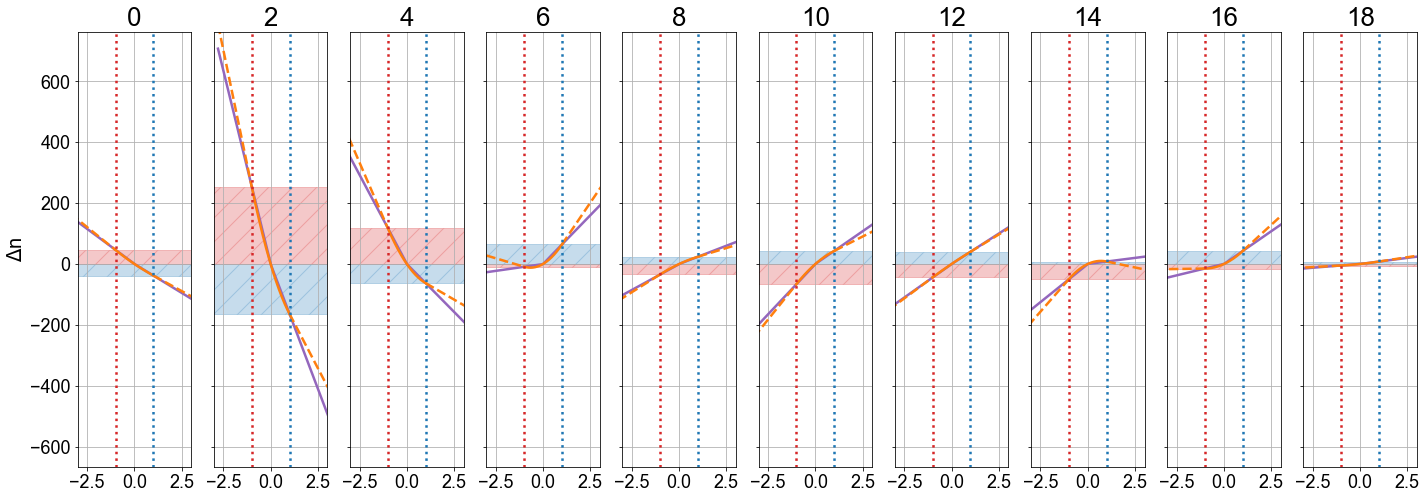

In [61]:
# check out the morphing function in a few bins
nbins = bins[:-1:2].size
fig, axes = plt.subplots(1, nbins, figsize=(24, 8), facecolor='white', sharey=True)

x = np.linspace(-5, 5, 601)
de_plus, de_minus = h_up - h_nom, h_down - h_nom
for i, ibin in enumerate(bins[:-1:2].astype(int)):
    ax = axes[i]
    
    # alternative function
    if de_minus[ibin]*de_plus[ibin] >= 0:
        de_max = np.max([de_plus[ibin], de_minus[ibin]])
        de_min = np.min([de_plus[ibin], de_minus[ibin]])
        if de_max > 0:
            f = softplus(x, a=de_max) 
        else:
            f = -softplus(x, a=de_min) 
    else:
        de_up, de_down = de_plus[ibin], de_minus[ibin]
        a1 = np.log((np.exp(de_up) - np.exp(de_up + de_down))/(np.exp(de_up + de_down) - np.exp(de_down)))
        a2 = np.log((1 - np.exp(de_down))/(np.exp(de_up) - 1))
        f = softplus(x, a=-a2) - softplus(x, a=-a1)
    
    #ax.plot(x, softplus(x, -a2), 'C0--')
    #ax.plot(x, -softplus(x, -a1), 'C3--')
    ax.plot(x, f, 'C4-')
    
    #nominal function
    delta_plus, delta_minus = de_plus[ibin] + de_minus[ibin], de_plus[ibin] - de_minus[ibin]
    x_low = np.linspace(-5, -1, 400)
    x_mid = np.linspace(-1, 1, 200)
    x_high = np.linspace(1, 5, 400)
    f_low = (-delta_plus + 0.5*delta_minus)*x_low - 0.5*delta_plus
    f_mid = 0.5*delta_plus*x_mid**2 + 0.5*delta_minus*x_mid
    f_high = (delta_plus + 0.5*delta_minus)*x_high - 0.5*delta_plus
    
    ax.plot(x_low, f_low, 'C1--', label='linear extrap.')
    ax.plot(x_mid, f_mid, 'C1-', label='quadratic interp.')
    ax.plot(x_high, f_high, 'C1--', label='_nolegend_')
    
    # extra dressing
    ax.fill_between([-5, 5], [0, 0], [de_plus[ibin], de_plus[ibin]], color='C0', hatch='/', alpha=0.25, label=r'up variation')
    ax.fill_between([-5, 5], [de_minus[ibin], de_minus[ibin]], [0, 0], color='C3', hatch='/', alpha=0.25, label=r'down variation')

    ##ax.set_ylim(-20, 10)
    #ax.set_xlabel(r'$\theta$')
    if ibin == 0:
        ax.set_ylabel(r'$\Delta n$')
        y_max = np.max(np.concatenate([de_plus, de_minus]))
        y_min = np.min(np.concatenate([de_plus, de_minus]))
        ax.set_ylim(3*y_min, 3*y_max)
        
    if ibin == 9:
        ax.set_xlabel(r'$\theta$')
        
    ax.plot([1, 1], [3*y_min, 3*y_max], 'C0:', label=r'$+1 \sigma$')
    ax.plot([-1, -1], [3*y_min, 3*y_max], 'C3:', label=r'$-1 \sigma$')
    ax.set_xlim(-3, 3)
    ax.set_title(f'{ibin}')
    ax.grid()
    #ax.legend()
    
plt.savefig('plots/stats/morphing_bins.pdf')
plt.show()

In [26]:
# initialize fit data
infile = open('local_data/fit_data_test.pkl', 'rb')
fit_data = pickle.load(infile)
decay_map = fit_data._decay_map
ww_labels = decay_map.fancy_label.values 

# get parameter data
parameters = fit_data._parameters

In [27]:
# construct morphing function for a single bin
sdata = fit_data.get_selection_data('mumu')
templates = sdata['cat_gt2_eq1_b']['templates']['ttbar']['wmu_wmu']
bins = sdata['cat_gt2_eq1_b']['bins']

t_nom, t_up, t_down = templates['val'].values, templates['escale_mu_up'].values, templates['escale_mu_down'].values
dt_up = t_up - t_nom
dt_down = t_down - t_nom

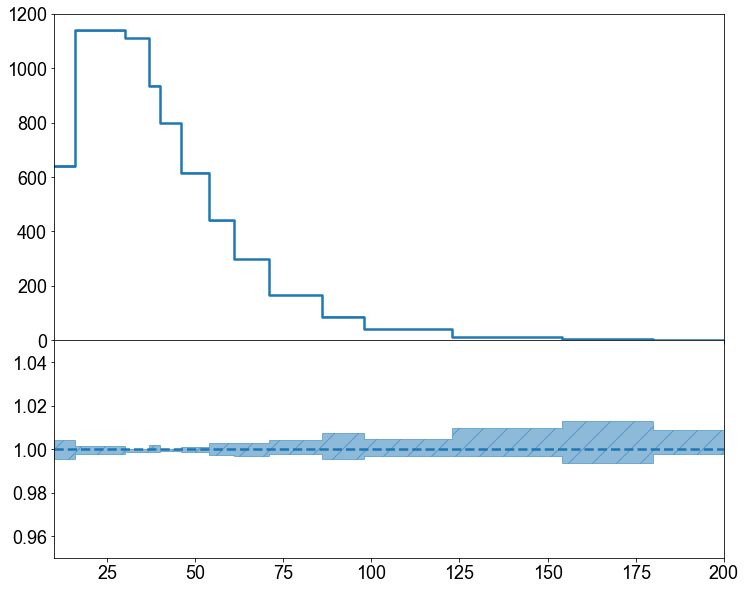

In [28]:
# make variation plot
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
x = bins[:-1]
dx = bins[1:] - bins[:-1]
ax.plot(bins[:-1], t_nom/dx, drawstyle='steps-post')
ax.fill_between(bins[:-1], t_down/dx, t_up/dx, color='C0', step='post', hatch='/', alpha=0.5)
ax.set_xlim(10, 200)
ax.set_ylim(0, None)

ax = axes[1]
ax.plot(bins[:-1], np.ones(bins.size -1), '--')
ax.fill_between(bins[:-1], t_down/t_nom, t_up/t_nom, color='C0', step='post', hatch='/', alpha=0.5)
ax.set_xlim(10, 200)
ax.set_ylim(0.95, 1.05)

plt.show()

4.960392796961287 -3.32042602258025


/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


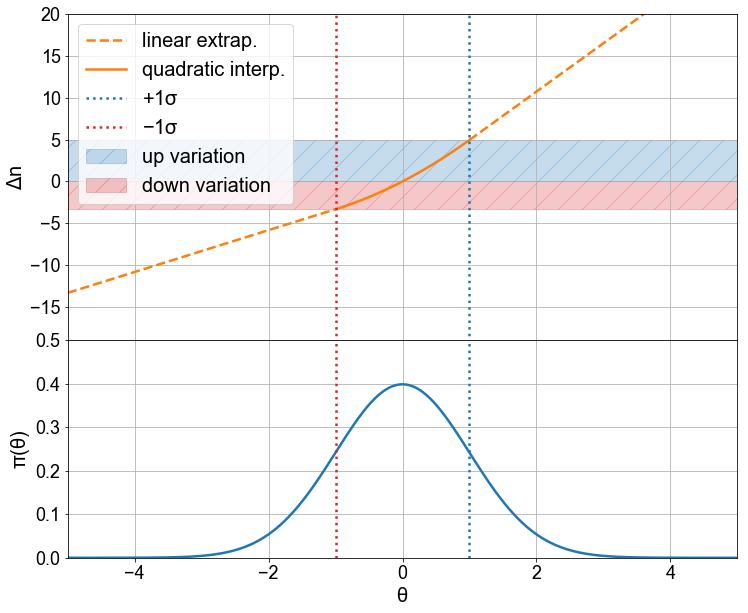

In [30]:
# plot morphing function for a single bin
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
ibin = 10
delta_plus, delta_minus = dt_up[ibin] + dt_down[ibin], dt_up[ibin] - dt_down[ibin]
print(dt_up[ibin], dt_down[ibin])
x_low = np.linspace(-5, -1, 400)
x_mid = np.linspace(-1, 1, 200)
x_high = np.linspace(1, 5, 400)
f_low = (-delta_plus + 0.5*delta_minus)*x_low - 0.5*delta_plus
f_mid = 0.5*delta_plus*x_mid**2 + 0.5*delta_minus*x_mid
f_high = (delta_plus + 0.5*delta_minus)*x_high - 0.5*delta_plus

ax.set_ylabel(r'$\Delta n$')
ax.plot(x_low, f_low, 'C1--', label='linear extrap.')
ax.plot(x_mid, f_mid, 'C1-', label='quadratic interp.')
ax.plot(x_high, f_high, 'C1--', label='_nolegend_')
ax.fill_between([-5, 5], [0, 0], [dt_up[ibin], dt_up[ibin]], color='C0', hatch='/', alpha=0.25, label=r'up variation')
ax.fill_between([-5, 5], [dt_down[ibin], dt_down[ibin]], [0, 0], color='C3', hatch='/', alpha=0.25, label=r'down variation')
ax.plot([1, 1], [-100, 100], 'C0:', label=r'$+1 \sigma$')
ax.plot([-1, -1], [-100, 100], 'C3:', label=r'$-1 \sigma$')
ax.set_ylim(-19, 20)
ax.grid()
ax.legend()

ax = axes[1]
from scipy.stats import norm
x = np.concatenate([x_low, x_mid, x_high])
ax.plot(x, norm.pdf(x), 'C0')
ax.plot([1, 1], [0, 1], 'C0:', label=r'$+1 \sigma$')
ax.plot([-1, -1], [0, 1], 'C3:', label=r'$-1 \sigma$')
ax.set_ylabel(r'$\pi(\theta)$')
ax.set_xlabel(r'$\theta$')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.5)
ax.grid()

plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


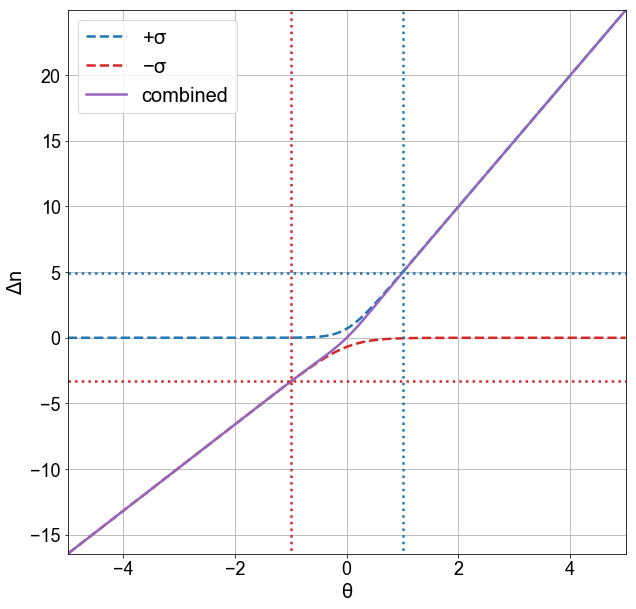

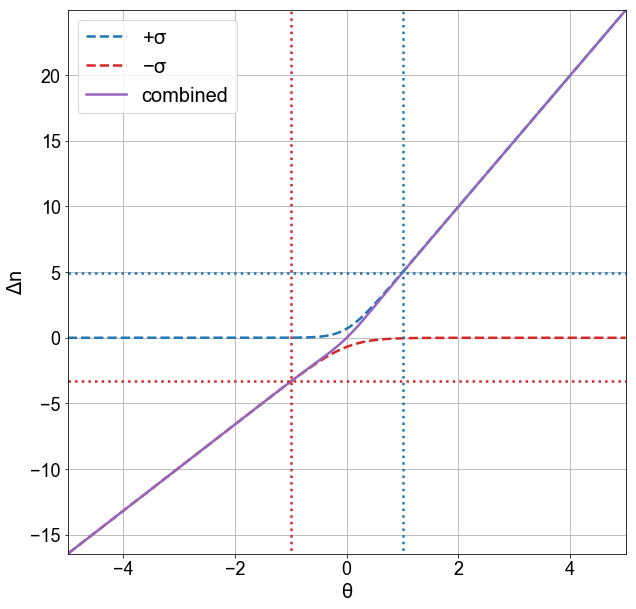

In [39]:
# possible function
fig, ax = plt.subplots(1, 1, figsize=(10, 10), facecolor='white')

x = np.linspace(-5, 5, 601)
de_plus, de_minus = 2., -5.
de_plus, de_minus = dt_up[ibin], dt_down[ibin]
a1 = np.log((np.exp(de_plus) - np.exp(de_plus + de_minus))/(np.exp(de_plus + de_minus) - np.exp(de_minus)))
a2 = np.log((1 - np.exp(de_minus))/(np.exp(de_plus) - 1))
f = softplus(x, a=-a2) - softplus(x, a=-a1)

ax.plot(x, softplus(x, -a2), 'C0--', label=r'$+\sigma$')
ax.plot(x, -softplus(x, -a1), 'C3--', label=r'$-\sigma$')
ax.plot(x, f, 'C4-', label='combined')

ax.plot([1, 1], [-100, 100], 'C0:')
ax.plot([-1, -1], [-100, 100], 'C3:')
ax.plot([-5, 5], [de_plus, de_plus], 'C0:')
ax.plot([-5, 5], [de_minus, de_minus], 'C3:')

ax.set_xlim(-5, 5)
ax.set_ylim(f[0], f[-1])
#ax.set_ylim(-20, 10)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\Delta n$')
ax.legend()
ax.grid()

plt.savefig('plots/stats/softplus_sum.pdf')
plt.show()

/home/naodell/opt/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


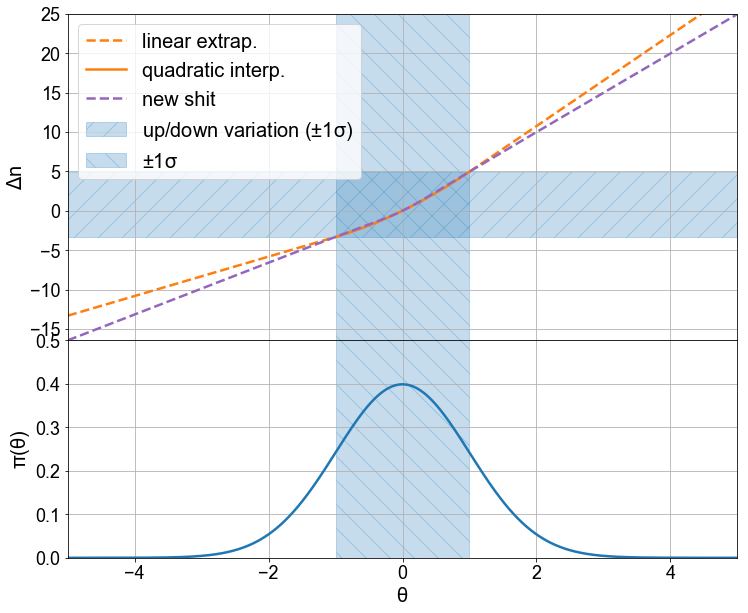

In [32]:
# plot morphing function for a single bin
fig, axes = plt.subplots(2, 1, figsize=(12, 10), facecolor='white', sharex=True, gridspec_kw={'height_ratios': [3, 2]})
fig.subplots_adjust(hspace=0)

ax = axes[0]
x_low = np.linspace(-5, -1, 400)
x_mid = np.linspace(-1, 1, 200)
x_high = np.linspace(1, 5, 400)
f_low = (-delta_plus + 0.5*delta_minus)*x_low - 0.5*delta_plus
f_mid = 0.5*delta_plus*x_mid**2 + 0.5*delta_minus*x_mid
f_high = (delta_plus + 0.5*delta_minus)*x_high - 0.5*delta_plus

ax.set_ylabel(r'$\Delta n$')
ax.plot(x_low, f_low, 'C1--', label='linear extrap.')
ax.plot(x_mid, f_mid, 'C1-', label='quadratic interp.')
ax.plot(x_high, f_high, 'C1--', label='_nolegend_')

x = np.linspace(-5, 5, 601)
ax.plot(x, f, 'C4--', label='new shit')

ax.fill_between([-5, 5], [dt_down[ibin], dt_down[ibin]], [dt_up[ibin], dt_up[ibin]], color='C0', hatch='/', alpha=0.25, label=r'up/down variation ($\pm 1 \sigma$)')
ax.fill_betweenx([-200, 100], [-1, -1], [1, 1], color='C0', hatch='\\', alpha=0.25, label=r'$\pm 1 \sigma$')
#ax.set_ylim(f[0], 20)#f[-1])
ax.set_ylim(f[0], f[-1])
ax.grid()
ax.legend()

ax = axes[1]
from scipy.stats import norm
x = np.concatenate([x_low, x_mid, x_high])
ax.plot(x, norm.pdf(x), 'C0')
ax.fill_betweenx([-0.1, 1], [-1, -1], [1, 1], color='C0', hatch='\\', alpha=0.25)
ax.set_ylabel(r'$\pi(\theta)$')
ax.set_xlabel(r'$\theta$')
ax.set_xlim(-5, 5)
ax.set_ylim(0, 0.5)
ax.grid()

plt.show()